# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings


from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool, ProjectedGradientDescent
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
warnings.filterwarnings('ignore')
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')
tf.compat.v1.disable_eager_execution()

In [2]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

lfw_dataset.target

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]

mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(y)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(X,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
(1140, 62, 47)
(1140, 62, 47, 1)
(912, 62, 47, 1)
(228, 62, 47, 1)
(912, 5)
(228, 5)


In [35]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4480)              0         
                                                                 
 dense_3 (Dense)             (None, 512)              

In [4]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Процесс генерации логов будет идти параллельно обучению, потому мы используем
# коллбэки.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [5]:
# model = keras.models.load_model("VGG_model_87.pth")
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
#
# # model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)
# his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=1000)

In [6]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=1000, batch_size=64, callbacks=[tensorboard_callback])

Train on 912 samples, validate on 228 samples
Metal device set to: Apple M1
Epoch 1/1000


2023-05-30 16:32:38.288209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-30 16:32:38.288384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-30 16:32:38.303375: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-30 16:32:38.303539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-30 16:32:38.328276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-30 16:32:38.482364: I tensorflow/core/grappler/o

256/912 [=======>......................] - ETA: 1s - loss: 116.9298 - accuracy: 0.1914

2023-05-30 16:32:38.792134: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-05-30 16:32:38.792150: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-05-30 16:32:38.865454: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-30 16:32:38.866045: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-05-30 16:32:38.867333: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20230530-163237/plugins/profile/2023_05_30_16_32_38

2023-05-30 16:32:38.867618: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20230530-163237/plugins/profile/2023_05_30_16_32_38/roman.local.trace.json.gz
2023-05-30 16:32:38.868888: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20230530-163237/plugins/profile/2023_05_3

912/912 [==============================] - ETA: 0s - loss: 38.6085 - accuracy: 0.3114

2023-05-30 16:32:39.306088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


912/912 [==============================] - 3s 3ms/sample - loss: 38.6085 - accuracy: 0.3114 - val_loss: 1.7885 - val_accuracy: 0.1491
Epoch 2/1000
912/912 [==============================] - 2s 2ms/sample - loss: 1.4520 - accuracy: 0.4178 - val_loss: 1.3931 - val_accuracy: 0.4825
Epoch 3/1000
912/912 [==============================] - 2s 3ms/sample - loss: 1.2996 - accuracy: 0.5066 - val_loss: 1.2401 - val_accuracy: 0.5307
Epoch 4/1000
912/912 [==============================] - 2s 2ms/sample - loss: 0.9568 - accuracy: 0.6382 - val_loss: 0.9862 - val_accuracy: 0.6623
Epoch 5/1000
912/912 [==============================] - 2s 2ms/sample - loss: 0.6979 - accuracy: 0.7423 - val_loss: 0.9595 - val_accuracy: 0.6404
Epoch 6/1000
912/912 [==============================] - 2s 2ms/sample - loss: 0.5775 - accuracy: 0.7993 - val_loss: 0.9234 - val_accuracy: 0.6491
Epoch 7/1000
912/912 [==============================] - 1s 2ms/sample - loss: 0.3938 - accuracy: 0.8640 - val_loss: 0.5820 - val_accurac

KeyboardInterrupt: 

In [8]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 88.16%


В контексте атак вредоносного машинного обучения, рассмотрим классификацию трех основных типов атак: атака с изменением пикселей, атака с добавлением шума и атака с заменой пикселей. Далее приведены примеры алгоритмов, относящихся к каждой из этих категорий:

Атака с изменением пикселей:

Fast Gradient Sign Method (FGSM): алгоритм, основанный на использовании градиента целевой функции для изменения значений пикселей с целью вызвать неправильную классификацию модели.
Basic Iterative Method (BIM): итерационный алгоритм, в котором значения пикселей итеративно изменяются с использованием градиента модели.
Projected Gradient Descent (PGD): алгоритм, который итеративно изменяет значения пикселей с использованием градиента, но с ограничением изменений в пределах допустимого диапазона значений.
Атака с добавлением шума:

Additive White Gaussian Noise (AWGN): атака, при которой случайный шум добавляется к значениям пикселей, чтобы вызвать неправильные предсказания модели.
Universal Perturbation: алгоритм, который находит универсальное искажение, которое можно добавить к любому изображению для обмана модели.
DeepFool: алгоритм, который вычисляет наименьшее искажение, необходимое для перемещения исходного изображения в область, где модель совершает неправильную классификацию.
Атака с заменой пикселей:

Boundary Attack: алгоритм, который исследует границу решений модели и находит точки, близкие к границе, для замены пикселей и вызова неправильных предсказаний.
One Pixel Attack: атака, при которой один или несколько пикселей в изображении заменяются таким образом, чтобы вызвать неправильную классификацию модели.
Genetic Algorithm-based Attack: атака, которая использует генетические алгоритмы для нахождения оптимальн

In [12]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [13]:
def attack(classifier, method, x, y, eps):
    attack = method(estimator=classifier, eps=eps)
    x_adv = attack.generate(x)
    loss, accuracy = model.evaluate(x_adv, y)
    print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
    return x_adv

In [14]:
x_adv = attack(classifier, FastGradientMethod ,x_train, y_train, eps=10/255)

2023-05-30 20:21:06.914396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-30 20:21:07.201117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 100.0%


In [20]:
accuracy_fgsm = []
eps = np.linspace(1e-3, 1, 20)
for _eps in eps:
    x_adv = attack(classifier, FastGradientMethod, x_test, y_test, eps=_eps)
    loss, accuracy = model.evaluate(x_adv, y_test)
    accuracy_fgsm.append(accuracy)

Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on adversarial test examples: 88.15789818763733%
Accuracy on ad

In [21]:
def plot(x, y, label, xlabel="eps", ylabel="accuracy"):
    fig, ax = plt.subplots()
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.patch.set_facecolor('white')
    # plt.show()
    # plt.savefig("FGSM_train_set.png", dpi=300, bbox_inches='tight')

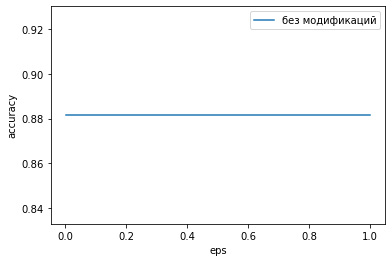

In [22]:
plot(eps, accuracy_fgsm, label="без модификаций")

In [17]:
# modify train data with fgsm attack and retrain the model
x_adv = []
y_adv_true = []
x_train_adv = attack(classifier, ProjectedGradientDescent, x_train[::6, :], y_train[::6, :], eps=0.02)
y_adv_true.append(y_train[::6, :])
x_adv.append(x_train_adv)
x_train_adv = attack(classifier, FastGradientMethod, x_train[::3, :], y_train[::3, :], eps=0.03)
y_adv_true.append(y_train[::3, :])
x_adv.append(x_train_adv)
x_train_adv = attack(classifier, FastGradientMethod, x_train[::4, :], y_train[::4, :], eps=0.04)
y_adv_true.append(y_train[::4, :])
x_adv.append(x_train_adv)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 29.629629850387573%
Accuracy on adversarial test examples: 35.18518507480621%
Accuracy on adversarial test examples: 20.000000298023224%


In [18]:
x_add_adv_data = np.array(x_train)
y_add_adv_data = np.array(y_train)
for i in range(len(x_adv)):
    x_add_adv_data = np.append(x_add_adv_data, x_adv[i]).reshape(-1, 62, 47, 1)
    y_add_adv_data = np.append(y_add_adv_data, y_adv_true[i]).reshape(-1, 5)

In [19]:
# x_add_adv_data = np.append(x_train, x_train_adv).reshape(-1, 62, 47, 1)
# y_add_adv_data = np.append(y_train, y_train[::3, :]).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

((281, 62, 47, 1), (281, 5))

In [25]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=10, batch_size=32)

Train on 281 samples, validate on 41 samples
Epoch 1/10
281/281 [==============================] - 0s 1ms/sample - loss: 0.1397 - accuracy: 0.9609 - val_loss: 0.7523 - val_accuracy: 0.7073
Epoch 2/10
281/281 [==============================] - 0s 2ms/sample - loss: 0.1039 - accuracy: 0.9822 - val_loss: 0.7440 - val_accuracy: 0.7073
Epoch 3/10
281/281 [==============================] - 0s 1ms/sample - loss: 0.0762 - accuracy: 0.9929 - val_loss: 0.9420 - val_accuracy: 0.7317
Epoch 4/10
281/281 [==============================] - 0s 921us/sample - loss: 0.0747 - accuracy: 0.9893 - val_loss: 0.6791 - val_accuracy: 0.8049
Epoch 5/10
281/281 [==============================] - 0s 1ms/sample - loss: 0.0592 - accuracy: 0.9893 - val_loss: 0.9221 - val_accuracy: 0.7561
Epoch 6/10
281/281 [==============================] - 0s 1ms/sample - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.7533 - val_accuracy: 0.7317
Epoch 7/10
281/281 [==============================] - 0s 967us/sample - loss: 0.0253 - ac

In [28]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=10, batch_size=64)

Train on 160 samples, validate on 41 samples
Epoch 1/10
160/160 [==============================] - 0s 772us/sample - loss: 0.0252 - accuracy: 1.0000 - val_loss: 0.7962 - val_accuracy: 0.7073
Epoch 2/10
160/160 [==============================] - 0s 721us/sample - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.7218 - val_accuracy: 0.7561
Epoch 3/10
160/160 [==============================] - 0s 1ms/sample - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.6278 - val_accuracy: 0.7317
Epoch 4/10
160/160 [==============================] - 0s 953us/sample - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.5760 - val_accuracy: 0.8537
Epoch 5/10
160/160 [==============================] - 0s 753us/sample - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.5562 - val_accuracy: 0.8293
Epoch 6/10
160/160 [==============================] - 0s 787us/sample - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.5540 - val_accuracy: 0.8293
Epoch 7/10
160/160 [==============================] - 0s 932us/sample - loss: 0.0

In [25]:
accuracy_fgsm_after_modification = []
# eps = np.linspace(1e-4, 0.04, 20)
eps = [10/255]
for _eps in eps:
    x_adv = attack(classifier, FastGradientMethod, x_train, y_train, eps=_eps)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm_after_modification.append(accuracy)

Accuracy on adversarial test examples: 100.0%


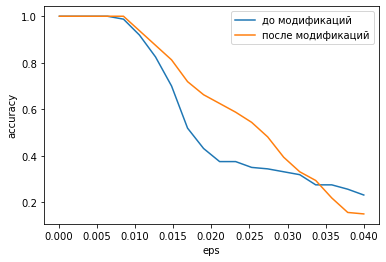

In [35]:
fig, ax = plt.subplots()
ax.plot(eps, accuracy_fgsm, label='до модификаций')
ax.plot(eps, accuracy_fgsm_after_modification, label='после модификаций')
ax.set_xlabel('eps')
ax.set_ylabel('accuracy')
ax.legend()
fig.patch.set_facecolor('white')
# plt.show()
plt.savefig("Обучение модели с модификацией данных вредоносными(попытка2).png", dpi=300, bbox_inches='tight')

In [33]:
x_adv = attack(classifier, FastGradientMethod, x_train, y_train, eps=100)

Accuracy on adversarial test examples: 91.11841917037964%


In [36]:
%load_ext tensorboard

In [31]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

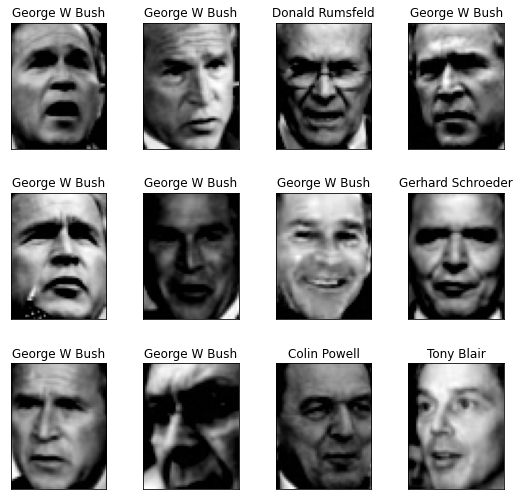

In [34]:
plot_gallery(x_adv, model.predict(x_adv))

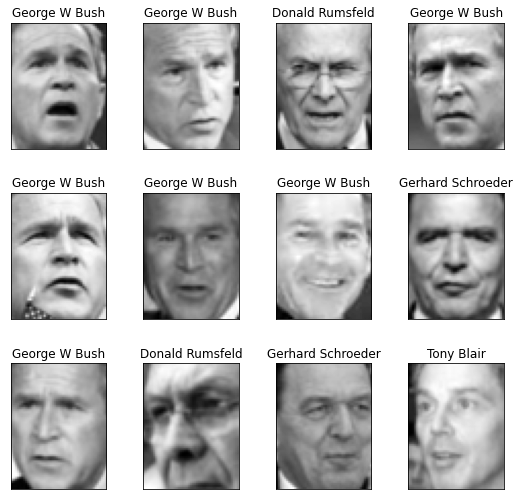

In [17]:
plot_gallery(x_train, y_train)